In [1]:
from datetime import datetime
print(f'Current Date/Time: {datetime.now()}')

Current Date/Time: 2020-09-26 20:11:26.611044


In [2]:
!rm -rf pytorch_utils
!git clone https://github.com/toniqapps/pytorch_utils.git

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 83 (delta 49), reused 17 (delta 6), pack-reused 0
Unpacking objects: 100% (83/83), done.


In [3]:
!pip install torchsummary

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

### Load CIFAR10 Dataset

In [5]:
from pytorch_utils import dataset

train, test = dataset.cifar10()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
trainloader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
testloader = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


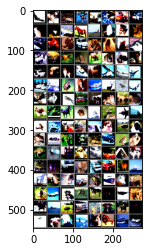

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class QuizDNN(nn.Module):

    def conv_block (self, in_channels, out_channels, kernel_size = 3, padding = 1):
      return nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(0.01))

    def __init__(self, opts=[]):
        super(QuizDNN, self).__init__()
        self.input = self.conv_block(3, 32)
        self.conv1 = self.conv_block(32, 32)
        self.conv2 = self.conv_block(32, 32)
        self.conv3 = self.conv_block(32, 32)
        self.conv4 = self.conv_block(32, 32)
        self.conv5 = self.conv_block(32, 32)
        self.conv6 = self.conv_block(32, 32)
        self.conv7 = self.conv_block(32, 32)
        self.conv8 = self.conv_block(32, 32)
        self.pool = nn.MaxPool2d(2, 2)
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=8))
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x1 = self.input(x) # 32 x 32 x 32
        x2 = self.conv1(x1) # 32x32x32
        #print(x1.shape, x2.shape)
        x3 = self.conv2(x1 + x2) #32x32x32
        x4 = self.pool(x1 + x2 + x3) #16x16x32
        x5 = self.conv3(x4) #16x16x32
        x6 = self.conv4(x4 + x5) #16x16x32
        x7 = self.conv5(x4 + x5 + x6) #16x16x32
        x8 = self.pool(x5 + x6 + x7) #8x8x32
        x9 = self.conv6(x8) #8x8x32
        x10 = self.conv7(x8 + x9) #8x8x32
        x11 = self.conv8(x8 + x9 + x10) #8x8x32
        x12 = self.gap(x11) #1x1x32
        x13 = self.fc(x12.view(x12.size(0), -1)) #1x1x10
        x = x13.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [10]:
from torchsummary import summary

net = QuizDNN().to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,216
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
          Dropout-12           [-1, 32, 32, 32]               0
        MaxPool2d-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1, 32,

In [11]:
import torch.optim as optim
from pytorch_utils import train, test
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

model_name = 'cifar_10_plot'

train_losses = dict()
train_acc = dict()
test_losses = dict()
test_acc = dict()

train_losses[model_name] = []
train_acc[model_name] = []
test_losses[model_name] = []
test_acc[model_name] = []

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    tr_loss, tr_acc = train.train(net, device, trainloader, optimizer, criterion, epoch, [], dict())
    train_losses[model_name].extend(tr_loss)
    train_acc[model_name].extend(tr_acc)
    te_loss, te_acc = test.test(net, device, testloader, criterion)
    test_losses[model_name].extend(te_loss)
    test_acc[model_name].extend(te_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.2022547721862793 Batch_id=390 Accuracy=47.32: 100%|██████████| 391/391 [00:18<00:00, 21.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 5167/10000 (51.67%)

EPOCH: 1


Loss=1.0244405269622803 Batch_id=390 Accuracy=63.32: 100%|██████████| 391/391 [00:18<00:00, 21.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 6745/10000 (67.45%)

EPOCH: 2


Loss=0.7513875961303711 Batch_id=390 Accuracy=68.97: 100%|██████████| 391/391 [00:18<00:00, 21.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 6500/10000 (65.00%)

EPOCH: 3


Loss=0.589490532875061 Batch_id=390 Accuracy=72.19: 100%|██████████| 391/391 [00:18<00:00, 21.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 7099/10000 (70.99%)

EPOCH: 4


Loss=0.8535676002502441 Batch_id=390 Accuracy=74.27: 100%|██████████| 391/391 [00:18<00:00, 21.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 7092/10000 (70.92%)

EPOCH: 5


Loss=0.8677236437797546 Batch_id=390 Accuracy=75.60: 100%|██████████| 391/391 [00:18<00:00, 21.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 7294/10000 (72.94%)

EPOCH: 6


Loss=0.6161344051361084 Batch_id=390 Accuracy=76.03: 100%|██████████| 391/391 [00:18<00:00, 21.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 7239/10000 (72.39%)

EPOCH: 7


Loss=1.3391964435577393 Batch_id=390 Accuracy=77.41: 100%|██████████| 391/391 [00:18<00:00, 21.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 7350/10000 (73.50%)

EPOCH: 8


Loss=0.5130715370178223 Batch_id=390 Accuracy=77.75: 100%|██████████| 391/391 [00:18<00:00, 21.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7657/10000 (76.57%)

EPOCH: 9


Loss=0.4859803318977356 Batch_id=390 Accuracy=77.97: 100%|██████████| 391/391 [00:18<00:00, 21.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7503/10000 (75.03%)

EPOCH: 10


Loss=0.5094482898712158 Batch_id=390 Accuracy=78.26: 100%|██████████| 391/391 [00:18<00:00, 21.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7654/10000 (76.54%)

EPOCH: 11


Loss=0.6039443016052246 Batch_id=390 Accuracy=78.62: 100%|██████████| 391/391 [00:17<00:00, 21.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7627/10000 (76.27%)

EPOCH: 12


Loss=0.48551416397094727 Batch_id=390 Accuracy=78.98: 100%|██████████| 391/391 [00:18<00:00, 21.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7692/10000 (76.92%)

EPOCH: 13


Loss=0.4801487922668457 Batch_id=390 Accuracy=79.28: 100%|██████████| 391/391 [00:17<00:00, 21.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 6871/10000 (68.71%)

EPOCH: 14


Loss=0.5991522073745728 Batch_id=390 Accuracy=79.32: 100%|██████████| 391/391 [00:17<00:00, 22.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 7086/10000 (70.86%)

EPOCH: 15


Loss=0.5003955364227295 Batch_id=390 Accuracy=79.42: 100%|██████████| 391/391 [00:17<00:00, 22.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7785/10000 (77.85%)

EPOCH: 16


Loss=0.48797607421875 Batch_id=390 Accuracy=79.51: 100%|██████████| 391/391 [00:17<00:00, 22.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7797/10000 (77.97%)

EPOCH: 17


Loss=0.7459217309951782 Batch_id=390 Accuracy=79.92: 100%|██████████| 391/391 [00:17<00:00, 22.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7852/10000 (78.52%)

EPOCH: 18


Loss=0.6517205834388733 Batch_id=390 Accuracy=79.80: 100%|██████████| 391/391 [00:17<00:00, 21.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7628/10000 (76.28%)

EPOCH: 19


Loss=0.454346239566803 Batch_id=390 Accuracy=80.15: 100%|██████████| 391/391 [00:17<00:00, 21.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7682/10000 (76.82%)

EPOCH: 20


Loss=0.6171854734420776 Batch_id=390 Accuracy=80.50: 100%|██████████| 391/391 [00:17<00:00, 21.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7791/10000 (77.91%)

EPOCH: 21


Loss=0.7200860977172852 Batch_id=390 Accuracy=80.16: 100%|██████████| 391/391 [00:17<00:00, 21.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7875/10000 (78.75%)

EPOCH: 22


Loss=0.5973418951034546 Batch_id=390 Accuracy=80.52: 100%|██████████| 391/391 [00:17<00:00, 22.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7791/10000 (77.91%)

EPOCH: 23


Loss=0.5829825401306152 Batch_id=390 Accuracy=80.40: 100%|██████████| 391/391 [00:17<00:00, 21.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7891/10000 (78.91%)

EPOCH: 24


Loss=0.5469955205917358 Batch_id=390 Accuracy=80.55: 100%|██████████| 391/391 [00:17<00:00, 21.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7865/10000 (78.65%)

EPOCH: 25


Loss=0.5304132699966431 Batch_id=390 Accuracy=80.68: 100%|██████████| 391/391 [00:17<00:00, 21.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7777/10000 (77.77%)

EPOCH: 26


Loss=0.5926538705825806 Batch_id=390 Accuracy=80.62: 100%|██████████| 391/391 [00:17<00:00, 22.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7735/10000 (77.35%)

EPOCH: 27


Loss=0.6395763158798218 Batch_id=390 Accuracy=80.51: 100%|██████████| 391/391 [00:17<00:00, 22.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7861/10000 (78.61%)

EPOCH: 28


Loss=0.5301540493965149 Batch_id=390 Accuracy=80.72: 100%|██████████| 391/391 [00:17<00:00, 21.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7818/10000 (78.18%)

EPOCH: 29


Loss=0.612511157989502 Batch_id=390 Accuracy=80.61: 100%|██████████| 391/391 [00:17<00:00, 22.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7804/10000 (78.04%)

EPOCH: 30


Loss=0.5466102361679077 Batch_id=390 Accuracy=80.69: 100%|██████████| 391/391 [00:17<00:00, 22.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7704/10000 (77.04%)

EPOCH: 31


Loss=0.527315080165863 Batch_id=390 Accuracy=80.86: 100%|██████████| 391/391 [00:17<00:00, 22.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7758/10000 (77.58%)

EPOCH: 32


Loss=0.5326972603797913 Batch_id=390 Accuracy=80.91: 100%|██████████| 391/391 [00:17<00:00, 22.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7799/10000 (77.99%)

EPOCH: 33


Loss=0.3901430070400238 Batch_id=390 Accuracy=80.76: 100%|██████████| 391/391 [00:17<00:00, 22.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7756/10000 (77.56%)

EPOCH: 34


Loss=0.5364457368850708 Batch_id=390 Accuracy=80.91: 100%|██████████| 391/391 [00:17<00:00, 22.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7897/10000 (78.97%)

EPOCH: 35


Loss=0.5334056615829468 Batch_id=390 Accuracy=80.81: 100%|██████████| 391/391 [00:17<00:00, 22.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7646/10000 (76.46%)

EPOCH: 36


Loss=0.5636392831802368 Batch_id=390 Accuracy=80.94: 100%|██████████| 391/391 [00:17<00:00, 22.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7936/10000 (79.36%)

EPOCH: 37


Loss=0.544735312461853 Batch_id=390 Accuracy=81.05: 100%|██████████| 391/391 [00:17<00:00, 22.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7738/10000 (77.38%)

EPOCH: 38


Loss=0.5604576468467712 Batch_id=390 Accuracy=81.07: 100%|██████████| 391/391 [00:17<00:00, 22.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7715/10000 (77.15%)

EPOCH: 39


Loss=0.4830740988254547 Batch_id=390 Accuracy=81.21: 100%|██████████| 391/391 [00:17<00:00, 21.95it/s]



Test set: Average loss: 0.0050, Accuracy: 7885/10000 (78.85%)

